In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pandas import Series,DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import lightgbm as lgb
from tqdm import tqdm_notebook
import joblib

In [2]:
# 读入原数据
df = pd.read_csv("【东软集团A08】医保特征数据16000（修订版）.csv")
t = pd.DataFrame(df['RES'])
# 读入训练数据
temp = pd.read_csv("测试集数据.csv")
test0=temp['RES']

In [3]:
# 统计train,test所有列中的：数值类型的列
number_columns = [ col for col in df.columns if df[col].dtype != 'object']

In [4]:
# 统计 train中有哪些列包含NaN
train_nan_num = [] # train中数值类型的列
for col in number_columns:
    if df[col].isnull().sum() > 0:
        train_nan_num.append(col)

In [5]:
# 将空缺值用中位数替代
for col in train_nan_num:
    df[col].fillna(df[col].mean(), inplace=True) # 平均值替代

In [6]:
# 过滤低方差法
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.5) 
# 过滤原数据低方差
X_vt = pd.DataFrame(vt.fit_transform(df),columns=df.columns[vt.get_support()] )
# 过滤测试数据低方差
T_vt = pd.DataFrame(vt.fit_transform(temp),columns=temp.columns[vt.get_support()] )
X_vt.head()

,一天去两家医院的天数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,...,基本个人账户支付_SUM,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX
0,0.0,7.0,5.666667,3.0,2.166667,34.0,7.0,5.666667,3501.18,2541.293333,...,228.80,1742.19,16942.04,0.0,0.0,0.0,0.0,0.0,4.0,29.0
1,0.0,4.0,2.500000,2.0,1.333333,15.0,4.0,2.500000,2217.66,1637.358333,...,199.50,1172.07,10915.75,0.0,0.0,0.0,0.0,0.0,3.0,20.0
2,8.0,8.0,6.166667,3.0,2.166667,45.0,9.0,7.500000,3360.55,2583.053333,...,234.00,2403.20,17840.03,0.0,0.0,0.0,0.0,0.0,4.0,29.0
3,0.0,6.0,3.666667,2.0,1.833333,23.0,6.0,3.833333,3030.61,2057.720000,...,73.34,1299.72,13718.22,0.0,0.0,0.0,0.0,0.0,5.0,16.0
4,0.0,5.0,4.333333,1.0,1.000000,26.0,5.0,4.333333,2332.45,2196.315000,...,64.00,1505.65,14642.13,0.0,0.0,0.0,0.0,0.0,2.0,33.0


In [7]:
df = pd.concat([X_vt,t],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   一天去两家医院的天数         16000 non-null  float64
 1   月就诊天数_MAX          16000 non-null  float64
 2   月就诊天数_AVG          16000 non-null  float64
 3   月就诊医院数_MAX         16000 non-null  float64
 4   月就诊医院数_AVG         16000 non-null  float64
 5   就诊次数_SUM           16000 non-null  float64
 6   月就诊次数_MAX          16000 non-null  float64
 7   月就诊次数_AVG          16000 non-null  float64
 8   月统筹金额_MAX          16000 non-null  float64
 9   月统筹金额_AVG          16000 non-null  float64
 10  月药品金额_MAX          16000 non-null  float64
 11  月药品金额_AVG          16000 non-null  float64
 12  医院_就诊天数_MAX        16000 non-null  float64
 13  医院_就诊天数_AVG        16000 non-null  float64
 14  医院_统筹金_MAX         16000 non-null  float64
 15  医院_统筹金_AVG         16000 non-null  float64
 16  医院_药品_MAX          160

In [8]:
# 此处为清洗后，但未归一化的数据
X = df.drop('RES', axis=1) # 数据集
y = df['RES'] # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train= np.column_stack((X_train,y_train))
test = np.column_stack((X_test, y_test))

print("test_transaction shape : ", train.shape)
print("test_identity shape : ", test.shape)

test_transaction shape :  (11200, 68)
test_identity shape :  (4800, 68)


In [9]:
X_train.describe()   #查看训练集信息

,一天去两家医院的天数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,...,基本个人账户支付_SUM,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX
count,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,...,11200.000000,11200.00000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000
mean,1.859196,7.837946,5.863373,2.092679,1.730545,36.834196,8.417232,6.266157,3942.608409,2781.786184,...,127.935047,2183.66761,18223.023238,579.443574,420.024977,2.211023,379.670754,1.578075,5.342946,26.083681
std,5.182627,4.213675,3.381261,0.941156,0.718863,23.639128,5.183509,3.931509,2957.599603,1862.470022,...,210.404039,2388.13097,13121.194577,2311.086045,4678.683485,153.393080,1677.359049,92.161864,2.886794,12.281583
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,5.000000,3.500000,1.000000,1.000000,22.000000,5.000000,3.666667,2413.987500,1791.046667,...,0.000000,1088.87500,11690.442500,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000
50%,0.000000,7.000000,5.166667,2.000000,1.666667,32.000000,7.000000,5.333333,3120.565000,2253.160000,...,104.925000,1506.52500,14660.915000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,26.000000
75%,0.000000,10.000000,7.333333,3.000000,2.000000,46.000000,10.000000,7.833333,4473.460000,3136.935000,...,165.000000,2294.79000,20283.105000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,34.000000
max,108.000000,31.000000,30.000000,8.000000,7.000000,307.000000,75.000000,51.166667,44590.330000,37403.050000,...,8297.080000,31842.58000,232978.610000,53903.790000,157830.320000,12178.540000,43123.200000,8913.440000,39.000000,70.000000


In [10]:
# 统计数据中的NaN
X_train.isnull().sum()

一天去两家医院的天数       0
月就诊天数_MAX        0
月就诊天数_AVG        0
月就诊医院数_MAX       0
月就诊医院数_AVG       0
                ..
残疾军人补助_SUM       0
民政救助补助_SUM       0
城乡优抚补助_SUM       0
出院诊断病种名称_NN      0
出院诊断LENTH_MAX    0
Length: 67, dtype: int64

In [11]:
T_vt = T_vt.drop('就诊的月数', axis=1)
T_vt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 67 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   一天去两家医院的天数         1001 non-null   float64
 1   月就诊天数_MAX          1001 non-null   float64
 2   月就诊天数_AVG          1001 non-null   float64
 3   月就诊医院数_MAX         1001 non-null   float64
 4   月就诊医院数_AVG         1001 non-null   float64
 5   就诊次数_SUM           1001 non-null   float64
 6   月就诊次数_MAX          1001 non-null   float64
 7   月就诊次数_AVG          1001 non-null   float64
 8   月统筹金额_MAX          1001 non-null   float64
 9   月统筹金额_AVG          1001 non-null   float64
 10  月药品金额_MAX          1001 non-null   float64
 11  月药品金额_AVG          1001 non-null   float64
 12  医院_就诊天数_MAX        1001 non-null   float64
 13  医院_就诊天数_AVG        1001 non-null   float64
 14  医院_统筹金_MAX         1001 non-null   float64
 15  医院_统筹金_AVG         1001 non-null   float64
 16  医院_药品_MAX          1001 

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11200 entries, 14741 to 7270
Data columns (total 67 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   一天去两家医院的天数         11200 non-null  float64
 1   月就诊天数_MAX          11200 non-null  float64
 2   月就诊天数_AVG          11200 non-null  float64
 3   月就诊医院数_MAX         11200 non-null  float64
 4   月就诊医院数_AVG         11200 non-null  float64
 5   就诊次数_SUM           11200 non-null  float64
 6   月就诊次数_MAX          11200 non-null  float64
 7   月就诊次数_AVG          11200 non-null  float64
 8   月统筹金额_MAX          11200 non-null  float64
 9   月统筹金额_AVG          11200 non-null  float64
 10  月药品金额_MAX          11200 non-null  float64
 11  月药品金额_AVG          11200 non-null  float64
 12  医院_就诊天数_MAX        11200 non-null  float64
 13  医院_就诊天数_AVG        11200 non-null  float64
 14  医院_统筹金_MAX         11200 non-null  float64
 15  医院_统筹金_AVG         11200 non-null  float64
 16  医院_药品_MAX          11200

In [13]:
# 合并训练集，测试集
train = pd.merge(X_train, y_train, how="outer",left_index=True,right_index=True)
test = pd.merge(X_test, y_test, how="outer",left_index=True,right_index=True)

In [14]:
train.head()

,一天去两家医院的天数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,...,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX,RES
14741,0.0,7.0,6.500000,2.0,2.000000,39.0,7.0,6.500000,2327.55,2078.681667,...,1903.28,14673.09,0.00,0.00,0.0,0.00,0.0,7.0,60.0,0
11539,12.0,16.0,12.666667,4.0,3.333333,88.0,18.0,14.666667,7840.56,6743.401667,...,2477.36,38792.96,6542.43,0.00,0.0,3925.50,0.0,14.0,24.0,0
14634,0.0,6.0,4.333333,1.0,1.000000,26.0,6.0,4.333333,4636.51,2939.596667,...,1787.75,19597.33,0.00,0.00,0.0,0.00,0.0,2.0,9.0,0
11678,0.0,5.0,2.666667,1.0,1.000000,16.0,5.0,2.666667,8762.92,6162.725000,...,2630.49,56424.44,13253.54,29368.78,0.0,10602.77,0.0,5.0,34.0,0
12645,0.0,7.0,6.500000,2.0,1.666667,39.0,7.0,6.500000,2436.40,1892.935000,...,1148.14,12619.61,0.00,0.00,0.0,0.00,0.0,3.0,18.0,0


In [15]:
test.head()

,一天去两家医院的天数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,...,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX,RES
8756,6.0,17.0,13.166667,4.0,3.166667,85.0,20.0,14.166667,5325.45,3872.131667,...,3217.45,26178.65,0.00,0.0,0.0,0.00,0.0,9.0,30.0,0
4660,0.0,4.0,3.000000,2.0,1.666667,18.0,4.0,3.000000,3298.29,2054.540000,...,2210.21,13696.96,0.00,0.0,0.0,0.00,0.0,3.0,51.0,0
6095,0.0,5.0,4.333333,1.0,1.000000,26.0,5.0,4.333333,2310.10,1588.580000,...,1542.88,10590.55,0.00,0.0,0.0,0.00,0.0,5.0,13.0,0
304,0.0,8.0,5.833333,2.0,1.333333,35.0,8.0,5.833333,1765.66,1209.126667,...,673.18,8060.82,0.00,0.0,0.0,0.00,0.0,7.0,33.0,0
8241,8.0,11.0,7.000000,3.0,2.666667,50.0,12.0,8.333333,7376.30,3307.983333,...,711.80,19111.83,2036.27,0.0,0.0,1323.62,0.0,3.0,33.0,0


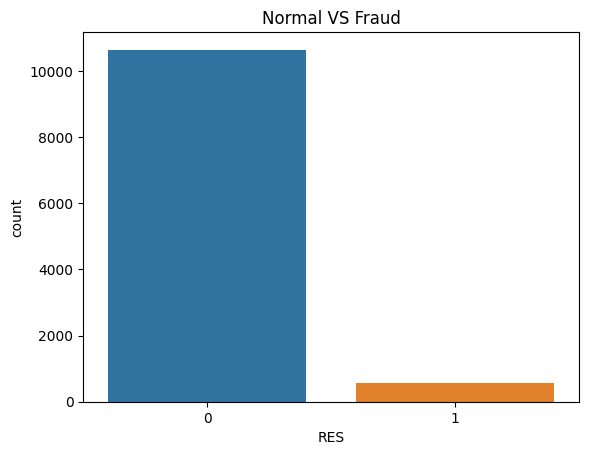

In [16]:
# 在train_transaction中，正负样本比例
sns.countplot(x="RES",data=train)
plt.title("Normal VS Fraud")
plt.show()

In [17]:
# params 超参数设置

params = {'num_leaves': 300, # 叶节点数量
          'min_data_in_leaf': 50, # 每个叶子节点中的数据
          'objective': 'binary', # 任务：二分类
          'max_depth': -1, # -1 ： 不限制深度
          "boosting_type": "gbdt", # 'dart', 'goss', 'rf'
          "metric": 'auc', # 衡量标准
          "verbosity" : -1, # 不显示信息
          'random_state': 50, # 随机种子
         }

In [18]:
# 创建DataFrame保存特征重要性
feature_importances = pd.DataFrame(index=None)
feature_importances['features'] = X_train.columns

In [19]:
feature_importances

,features
0,一天去两家医院的天数
1,月就诊天数_MAX
2,月就诊天数_AVG
3,月就诊医院数_MAX
4,月就诊医院数_AVG
...,...
62,残疾军人补助_SUM
63,民政救助补助_SUM
64,城乡优抚补助_SUM
65,出院诊断病种名称_NN


In [20]:
# 5折交叉验证
folds = KFold(n_splits=5)
splits = folds.split(X, y) # 分割成5份，前4份是训练集索引，最后1份是验证集索引

In [21]:
next(iter(splits)) # 输出的是索引

(array([ 3200,  3201,  3202, ..., 15997, 15998, 15999]),
 array([   0,    1,    2, ..., 3197, 3198, 3199]))

In [22]:
best_auc = 0
best_model = None
from lightgbm import log_evaluation, early_stopping

for k, (train_indices, val_indices) in enumerate(splits):
    print("第 %d 折\n" % k)
    X_train_data, X_val_data = X.iloc[train_indices], X.iloc[val_indices] # 训练集， 验证集
    y_train, y_val = y.iloc[train_indices], y.iloc[val_indices] # 训练标签，验证标签
    #print("X_train_data shape : \t", X_train_data.shape, "X_val_data shape : \t", X_val_data.shape)
    
    train_dataset = lgb.Dataset(X_train_data, label=y_train) # 训练集
    val_dataset = lgb.Dataset(X_val_data, label=y_val) # 验证集
    callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=30)] # 如果200轮后没有提升，就停止循环
    
    lgb_model = lgb.train(params=params, # 超参数设置
                          train_set=train_dataset, # 训练数据
                          num_boost_round=10000, # 循环的轮数
                          valid_sets=val_dataset, # 验证数据
                          valid_names='validation') 
    # 保存特征重要性
    feature_importances[f'fold_{k+1}'] = lgb_model.feature_importance()
    
    # 对验证集进行预测
    y_val_pred = lgb_model.predict(X_val_data)
    
    # 计算roc_auc
    roc_auc = roc_auc_score(y_val, y_val_pred)
    print(f" Fold {k + 1} | AUC_ROC ： { roc_auc * 100}%")


第 0 折

 Fold 1 | AUC_ROC ： 92.62470913321698%
第 1 折

 Fold 2 | AUC_ROC ： 92.75515084621044%
第 2 折

 Fold 3 | AUC_ROC ： 90.0409756097561%
第 3 折

 Fold 4 | AUC_ROC ： 90.79519259532984%


In [23]:
    # 判断是否是最优模型
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = lgb_model

In [24]:
feature_importances.shape

(67, 5)

In [25]:
feature_importances.head()

,features,fold_1,fold_2,fold_3,fold_4
0,一天去两家医院的天数,387,366,424,370
1,月就诊天数_MAX,1096,1144,987,1102
2,月就诊天数_AVG,1681,1511,1595,1518
3,月就诊医院数_MAX,237,152,147,233
4,月就诊医院数_AVG,1006,1029,941,989


In [26]:
feature_importances['average'] = feature_importances[[f'fold_{k+1}' for k in range(folds.n_splits-1)]].mean(axis=1)

In [27]:
feature_importances.head()

,features,fold_1,fold_2,fold_3,fold_4,average
0,一天去两家医院的天数,387,366,424,370,386.75
1,月就诊天数_MAX,1096,1144,987,1102,1082.25
2,月就诊天数_AVG,1681,1511,1595,1518,1576.25
3,月就诊医院数_MAX,237,152,147,233,192.25
4,月就诊医院数_AVG,1006,1029,941,989,991.25


In [28]:
print("The best roc_auc : ", roc_auc)

The best roc_auc :  0.9079519259532984


In [29]:
joblib.dump(best_model, "best_model.pkl") # 保存模型

['best_model.pkl']

In [30]:
# 对与test进行预测
test0.to_excel('./测试数据结果.xlsx')
y_test_pred = best_model.predict(T_vt)

In [31]:
y_test_pred.shape

(1001,)

In [32]:
labels = np.round(y_test_pred) # np.round() 四舍五入

In [33]:
from collections import Counter
Counter(labels)

Counter({0.0: 953, 1.0: 48})

In [34]:
# 导出最终结果

dd = pd.DataFrame(labels,columns=['Col1'])
dd.to_excel('./模型预测结果.xlsx')